**Bibliotecas Necessárias**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

**Módulos Necessários Para Previsão**

In [0]:
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
import xgboost as xgb

In [0]:
test = pd.read_csv('test.csv') # Abrir o DataFrame test
train = pd.read_csv('train.csv') # Abrir o DataFrame train

In [34]:
train.head()

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,...,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,1,1,4314902.0,Porto Alegre,43.0,RS,1,4,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,A,A,A,A,A,B,A,A,C,A,A,A,C,H,E,5.0,5.0,1.0,0.0,0.0,5,5,0,5,5,5,5,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,3,1,2304707.0,Granja,23.0,CE,2,0,2,1.0,0,23005157.0,2304707.0,Granja,23.0,CE,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,1,1,1,1,1,NaN,A,A,C,A,B,A,A,C,A
2,3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,3,1,2304400.0,Fortaleza,23.0,CE,3,0,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,A,A,A,A,A,B,A,A,B,A,A,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,5,5,5,5,5,NaN,A,A,A,A,C,A,A,B,A
3,4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,0,1,3304557.0,Rio de Janeiro,33.0,RJ,1,9,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,...,A,B,B,B,A,B,A,B,C,A,B,D,B,C,B,C,F,C,2.0,0.0,5.0,5.0,5.0,5,5,5,5,2,5,5,5.0,C,A,A,A,A,D,A,A,A
4,5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,2,1,1505304.0,Oriximiná,15.0,PA,1,4,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,B,A,A,A,A,B,A,A,B,A,A,A,B,F,D,5.0,4.0,3.0,5.0,4.0,5,5,4,3,1,4,5,NaN,A,A,A,A,A,A,A,A,A


In [35]:
train.describe() # Breve Análise Das Colunas Do DataFrame train

,Unnamed: 0,NU_ANO,CO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,NU_IDADE,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,CO_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_SABATISTA,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,...,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,IN_CERTIFICADO,CO_UF_ENTIDADE_CERTIFICACAO,CO_MUNICIPIO_PROVA,CO_UF_PROVA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q005,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041
count,13730.000000,13730.0,1.373000e+04,13730.000000,13730.000000,13202.000000,13730.000000,13730.000000,1.312100e+04,13121.000000,13730.000000,13730.000000,13730.000000,4282.000000,13730.000000,4.282000e+03,4.282000e+03,4282.000000,4282.000000,4282.000000,4282.000000,13730.000000,13730.0,13730.000000,13730.000000,13730.0,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.0,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.0,13730.000000,...,13730.0,13730.000000,13730.0,13730.0,13730.0,13730.000000,13730.000000,1638.000000,1.373000e+04,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,10341.000000,10341.000000,10133.000000,10133.000000,13730.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000,13730.000000,6355.000000,6355.000000,6354.000000,6354.000000,6354.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,2938.000000
mean,2288.173926,2016.0,3.088548e+06,30.736708,21.593809,0.116043,2.185652,1.048871,3.057946e+06,30.429159,1.782666,2.146176,1.353532,1.178888,0.129862,3.121720e+07,3.123638e+06,31.085474,2.259692,1.030827,1.001635,0.001238,0.0,0.000364,0.000510,0.0,0.002185,0.000146,0.000947,0.000073,0.000073,0.0,0.000437,0.000510,0.009687,0.000947,0.001602,0.000146,0.0,0.004151,...,0.0,0.000073,0.0,0.0,0.0,0.000364,0.119301,30.639194,3.085637e+06,30.709250,0.754479,0.754479,0.738747,0.738747,473.495155,529.661087,516.472841,482.497928,0.593664,1.101747,119.811704,111.915918,106.824238,113.123951,77.372446,529.048258,4.083467,3.833360,2.608812,4.375984,4.530217,3.962858,4.645594,4.678441,3.341515,4.458995,3.724618,3.506409,4.442098,3.671545
std,1321.230607,0.0,9.890495e+05,9.862405,7.043654,0.365986,1.007285,0.258895,9.703020e+05,9.670030,0.880734,3.217328,0.558472,0.565490,0.336163,9.540289e+06,9.574114e+05,9.546193,0.698586,0.172868,0.040404,0.035167,0.0,0.019080,0.022575,0.0,0.046695,0.012069,0.030757,0.008534,0.008534,0.0,0.020901,0.022575,0.097947,0.030757,0.039998,0.012069,0.0,0.064301,...,0.0,0.008534,0.0,0.0,0.0,0.019080,0.324154,9.884543,9.888721e+05,9.860227,0.431932,0.431932,0.440162,0.440162,71.093674,73.726344,68.688190,99.826323,0.491167,0.700100,29.846017,33.737588,34.341349,33.480033,43.067140,154.294758,1.603004,1.661301,2.234009,1.210998,1.027613,1.625356,0.920998,0.865039,1.711930,1.200172,1.689362,1.718858,1.181549,1.746444
min,0.000000,2016.0,1.100023e+06,11.000000,13.000000,0.000000,0.000000,0.000000,1.100023e+06,11.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.100189e+07,1.100023e+06,11.000000,1.000000,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,11.000000,1.100023e+06,11.000000,0.000000,0.

**Correlações**

---
Os Valores Abaixo São Absolutos Portanto Podem Ser Positivas ou Negativas

> * 0.00 a 0.19      --> *Correlação Muito Fraca*

> * 0.20 a 0.39      --> *Correlação Fraca*

> * 0.40 a 0.69      --> *Correlação Moderada*

> * 0.70 a 0.89      --> *Correlação Forte*

> * 0.90 a 1.00      --> *Correlação Muito Forte*





**Somente Correlações Maiores Que 0.37(*)**
* *Valor Absoluto

In [0]:
correlation = train.corr()
medium_high_corr = correlation[(correlation['NU_NOTA_MT'] < -0.37) | 
                        (correlation['NU_NOTA_MT'] >  0.37) & 
                        (correlation['NU_NOTA_MT'] < 1)
                        ]['NU_NOTA_MT']
correlation_list = medium_high_corr.index.tolist()
correlation_list_mat = correlation_list.copy() + ['NU_NOTA_MT']#Para Melhor Compreensão das Correlações No Gráfico Abaixo

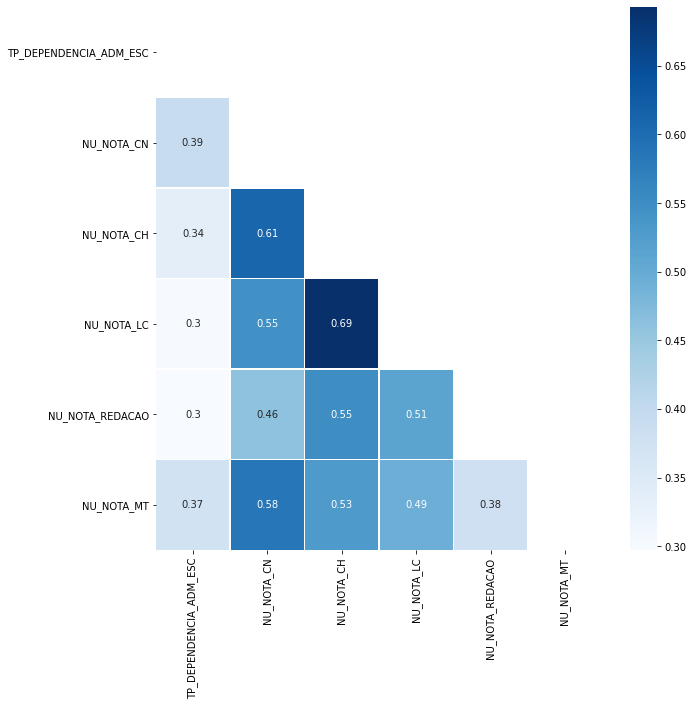

In [37]:
corr = train[correlation_list_mat].corr()
plt.figure(figsize=(10,10))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,
            mask=mask,
            annot=True,
            cmap='Blues',
            linewidths=.5,
            )

**Verificar Quantidade De NaN Nas Colunas Relacionadas**

In [38]:
train[correlation_list_mat].isnull().sum()

TP_DEPENDENCIA_ADM_ESC    9448
NU_NOTA_CN                3389
NU_NOTA_CH                3389
NU_NOTA_LC                3597
NU_NOTA_REDACAO           3597
NU_NOTA_MT                3597
dtype: int64

**Gerando Gráfico De Correlação**

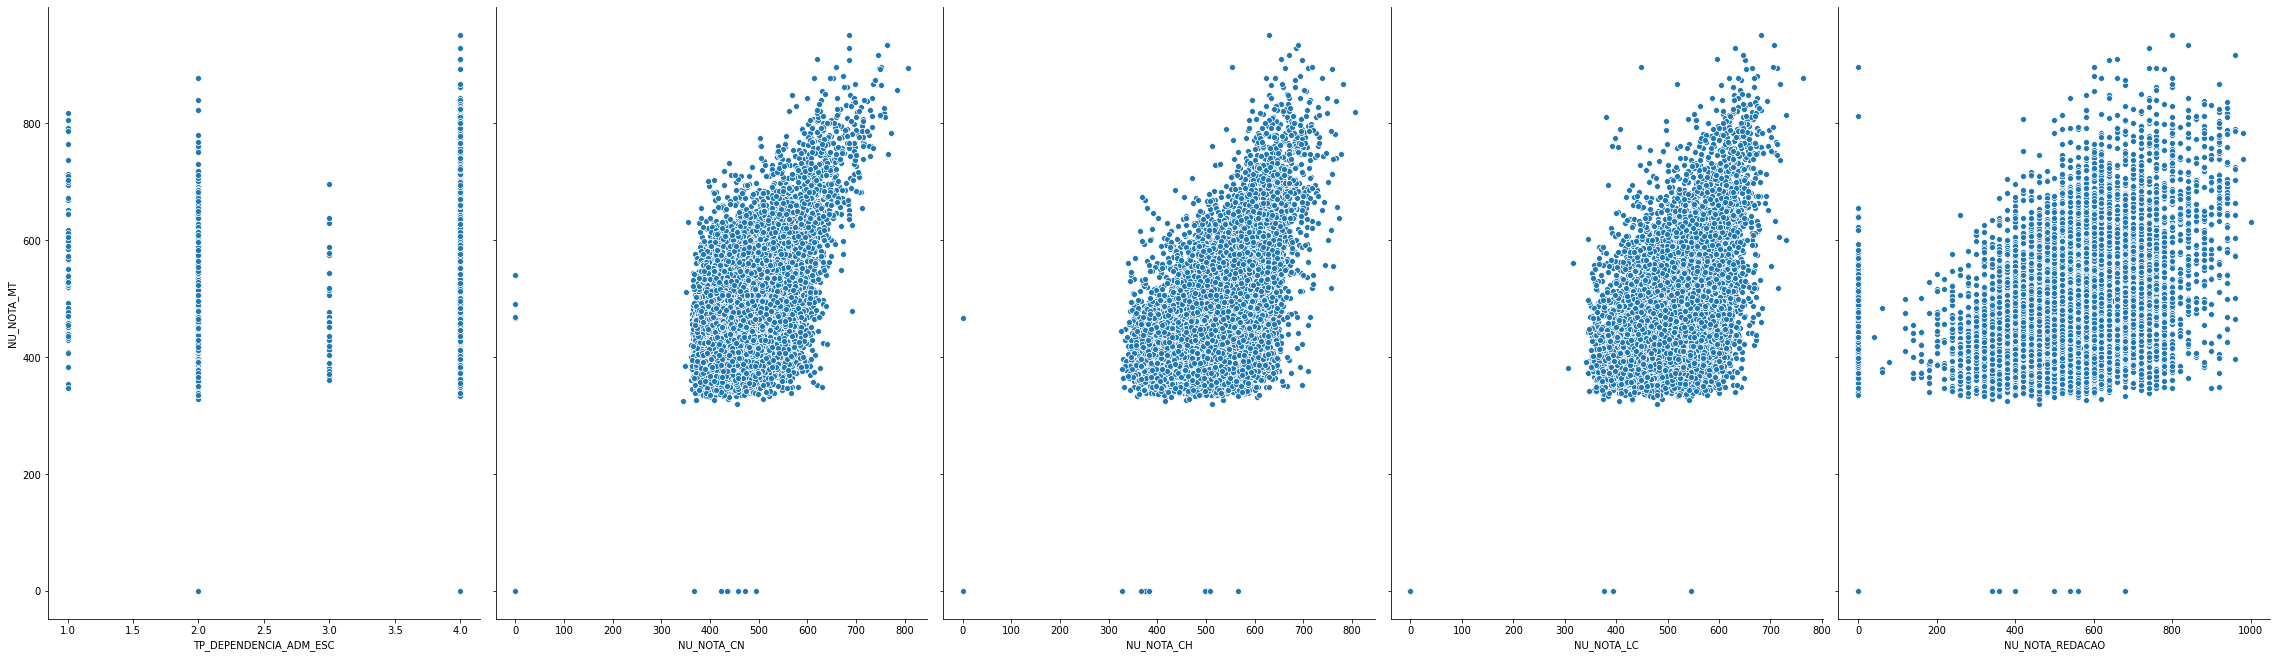

In [61]:
sns.pairplot(train, x_vars=correlation_list, y_vars='NU_NOTA_MT', height=9, aspect=0.7)

**Preenchendo Os Valores NaN Com 0**

In [0]:
X, y = train[correlation_list].copy(),train["NU_NOTA_MT"].copy()
for item in correlation_list:
  X[item].fillna(0, inplace=True)

In [0]:
y.fillna(0, inplace=True)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=193)

**XGB Regressor Com Randomized Search**

In [0]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.8, 
                          max_depth = 10, 
                          alpha = 10, 
                          n_estimators = 150
                          )
xg_reg_rand = RandomizedSearchCV(xg_reg, 
                                 {}, 
                                 random_state=42
                                 )

In [44]:
xg_reg_rand.fit(X_train,y_train)
preds = xg_reg_rand.predict(X_test)
print("RMSE: %f" % (np.sqrt(mean_squared_error(y_test, preds)))) #Mostra O RMSE (Raiz do Erro Quadrático Médio)
print("MSE: %f" % (np.square(np.subtract(y_test,preds)).mean())) #Mostra O MSE (Erro Quadrático Médio)
print("R²: %f" % (r2_score(y_test,preds))) #Mostra O R²(Coeficiente de Determinação)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RMSE: 65.225626
MSE: 4254.382227
r2: 0.917369


**Gradient Booster Com Randomized Search**


In [0]:
grad_boost = GradientBoostingRegressor(random_state=42)
grand_boost_rand = RandomizedSearchCV(grad_boost, 
                                      {}, 
                                      cv=5, 
                                      random_state=42)

In [46]:
grand_boost_rand.fit(X_train,y_train)
preds = grand_boost_rand.predict(X_test)
print("RMSE: %f" % (np.sqrt(mean_squared_error(y_test, preds))))
print("MSE: %f" % (np.square(np.subtract(y_test,preds)).mean()))
print("r2: %f" % (r2_score(y_test,preds)))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RMSE: 61.544738
MSE: 3787.754755
r2: 0.926433


**Random Forest Com Randomized Search**

In [0]:
rand_forest = RandomForestRegressor(max_depth=10, 
                                    random_state=42
                                    )
rand_forest_rand = RandomizedSearchCV(rand_forest, 
                                      {}, 
                                      cv=5, 
                                      random_state=42
                                      )

In [48]:
rand_forest_rand.fit(X_train,y_train)
preds = rand_forest_rand.predict(X_test)
print("RMSE: %f" % (np.sqrt(mean_squared_error(y_test, preds))))
print("MSE: %f" % (np.square(np.subtract(y_test,preds)).mean()))
print("r2: %f" % (r2_score(y_test,preds)))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RMSE: 62.200607
MSE: 3868.915499
r2: 0.924856


**Iniciando Previsoes Do Dataset Test Com Os Valores NaN Preenchidos Com 0**

In [0]:
# Creating The Answer Dataframe
answer = pd.DataFrame()
answer['NU_INSCRICAO'] = test['NU_INSCRICAO']
pred_test = test[correlation_list].fillna(0, inplace=False).copy()

In [0]:
pred_answer = grand_boost_rand.predict(pred_test) # Gradient Booster Com Randomized Search

In [0]:
answer['NU_NOTA_MT'] = np.around(pred_answer, 2)
answer.to_csv('answer.csv', index=False, header=True) # Remove O Index

In [0]:
pred_answer = xg_reg_rand.predict(pred_test) # XGB Regressor Com Randomized Search

In [0]:
answer['NU_NOTA_MT'] = np.around(pred_answer, 2)
answer.to_csv('answer2.csv', index=False, header=True) # Remove O Index

In [0]:
pred_answer = rand_forest_rand.predict(pred_test) # Random Forest Com Randomized Search

In [0]:
answer['NU_NOTA_MT'] = np.around(pred_answer, 2)
answer.to_csv('answer3.csv', index=False, header=True) # Remove O Index

**Preenchendo Valores NaN Com A Média**

In [0]:
Z, k = train[correlation_list].copy(), train["NU_NOTA_MT"].copy()
for item in correlation_list:
  Z[item].fillna(Z[item].mean(), inplace=True)

In [0]:
k.fillna(k.mean(), inplace=True)

In [0]:
Z_train, Z_test, k_train, k_test = train_test_split(Z, k, test_size=0.2, random_state=148)

In [59]:
xg_reg_rand.fit(Z_train, k_train)
preds = xg_reg_rand.predict(Z_test)
print("RMSE: %f" % (np.sqrt(mean_squared_error(k_test, preds))))
print("MSE: %f" % (np.square(np.subtract(k_test,preds)).mean()))
print("r2: %f" % (r2_score(k_test,preds)))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RMSE: 66.153265
MSE: 4376.254529
r2: 0.411086


In [60]:
grand_boost_rand.fit(Z_train, k_train)
preds = grand_boost_rand.predict(Z_test)
print("RMSE: %f" % (np.sqrt(mean_squared_error(k_test, preds))))
print("MSE: %f" % (np.square(np.subtract(k_test,preds)).mean()))
print("r2: %f" % (r2_score(k_test,preds)))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RMSE: 63.543727
MSE: 4037.805294
r2: 0.456631


**Devido Ao Baixo Valor de R2 Preferi Não Continuar**